This code takes the mosaicked carbon stock outputs and reprojects them onto an equal area grid so that we can convert carbon stock density into total carbon stocks. We also output density layers in the same projection to keep everything consistent.

In [1]:
# import packages
from rasterio.warp import Resampling
import geopandas as gpd
import numpy as np
import rioxarray
import xarray
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Point
import pyproj
from geopy.distance import geodesic

### First explore potential distortion surrounding study area, based on a LAEA projection centered at the center of the Y2Y region

In [2]:
# load y2y boundary
y2y = './study_area/Y2Y_RegionBoundary_Final2013/Y2Y_RegionBoundary.shp'

In [3]:
# find center of y2y region
# Load the shapefile
gdf = gpd.read_file(y2y)

# Reproject to WGS84 if necessary
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Get the bounding box (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = gdf.total_bounds

# Calculate the center (midpoint of the bounding box)
center_lon = (minx + maxx) / 2
center_lat = (miny + maxy) / 2

print(f"Latitude: {center_lat}, Longitude: {center_lon}")

Latitude: 54.53624536240069, Longitude: -124.66760996293321


/var/folders/61/b_g16g9n7h1864j7mrkvshbw0000gn/T/ipykernel_85749/1147800339.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


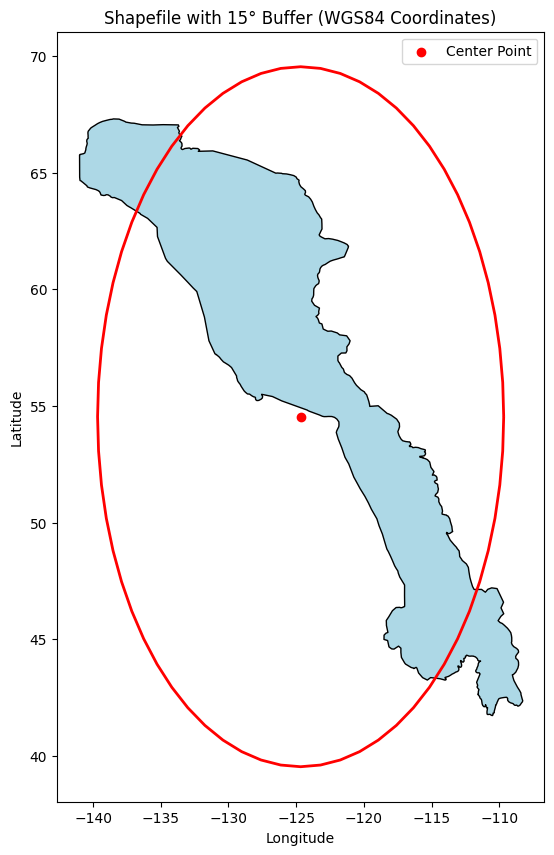

In [4]:
# LAEA projection is distorted less than 2% within 15 degrees from the center
# map Y2Y with 15 degree buffer
# Define the center point in WGS84 (latitude, longitude)
center_point = Point(center_lon, center_lat)

# Create a buffer of 15 degrees around the center
buffer_15deg = center_point.buffer(15)  # Buffer in degrees

# Convert the buffer into a GeoSeries for plotting
buffer_gs = gpd.GeoSeries([buffer_15deg], crs="EPSG:4326")

# Reproject the shapefile to WGS84, if not already
if gdf.crs != "EPSG:4326":
    gdf_wgs84 = gdf.to_crs("EPSG:4326")
else:
    gdf_wgs84 = gdf

# Plot the shapefile, center, and buffer
fig, ax = plt.subplots(figsize=(10, 10))
gdf_wgs84.plot(ax=ax, color="lightblue", edgecolor="black", label="Shapefile")
buffer_gs.plot(ax=ax, color="none", edgecolor="red", linewidth=2, label="15° Buffer")
ax.scatter(center_lon, center_lat, color="red", marker="o", label="Center Point", zorder=5)

# Add labels and legend
ax.set_title("Shapefile with 15° Buffer (WGS84 Coordinates)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# Show the plot
plt.show()

Distortion is minimal, a bit more at the far reaches of the region but acceptable for our application. Equal area is again a bigger concern.

### Reproject final carbon stock layers into the desired equal area project

In [5]:
# define print raster function to help compare reprojections
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
        f"NoDataValue: {raster.rio.nodata}\n"
        f"NoDataOriginalValues: {raster.rio.encoded_nodata}\n"
    )

In [6]:
# define laea projection centered on Y2Y
laea = '+proj=laea +lat_0=55 +lon_0=-125 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'

In [7]:
# load file paths for carbon rasters
#agb_path = './carbon_stock_data/output_layers/agb_c_spawn_t_ha.tif'
#bgb_path = './carbon_stock_data/output_layers/bgb_c_spawn_t_ha.tif'
carbon_path = './carbon_stock_data/output_layers/carbon_sothe_spawn_t_ha.tif'
carbon_err_path = './carbon_stock_data/output_layers/carbon_err_sothe_spawn_t_ha.tif'
soc_path = './carbon_stock_data/output_layers/soc_0_1m_t_ha.tif'
soc_err_path = './carbon_stock_data/output_layers/soc_err_0_1m_t_ha.tif'

In [8]:
# load file path for landcover raster
lc_path = './land_cover/landcover-2020-classification-y2y.tif'

In [9]:
# load data arrays
carbon = xarray.open_dataarray(carbon_path)
carbon_err = xarray.open_dataarray(carbon_err_path)
soc = xarray.open_dataarray(soc_path)
soc_err = xarray.open_dataarray(soc_err_path)
lc = xarray.open_dataarray(lc_path)

In [10]:
# print rasters
print_raster(carbon)
print_raster(carbon_err)
print_raster(soc)
print_raster(soc_err)
print_raster(lc)

shape: (9206, 11785)
resolution: (0.0027777777777779986, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 1017630848.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (9206, 11785)
resolution: (0.0027777777777779986, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 353329664.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (9206, 11785)
resolution: (0.0027777777777779986, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 5753465856.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (9206, 11785)
resolution: (0.0027777777777779986, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 2349441792.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (1

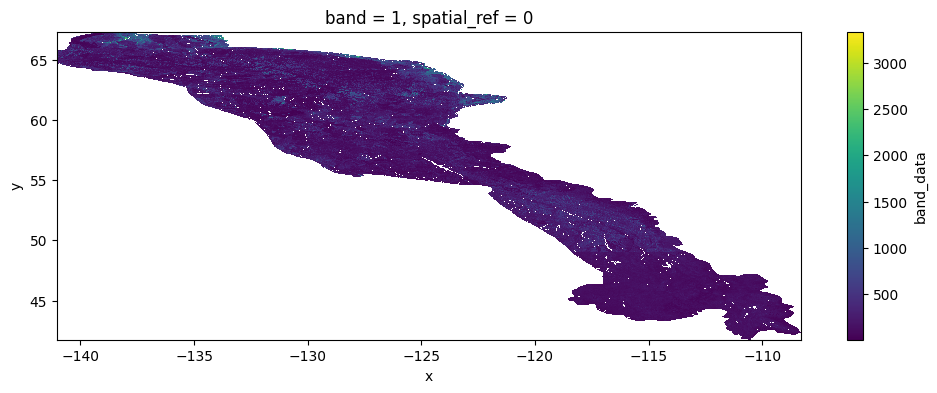

In [11]:
# # plot soc to check if nodata values are correct
# fig, ax = plt.subplots(ncols=1, figsize=(12,4))
# soc.plot(ax=ax)
# plt.draw()

In [12]:
# reproject carbon and soc layers
# use average resampling since these are density values
# 50% no data threshold
carbon_laea = carbon.rio.reproject(dst_crs = laea, resolution = 250, resampling = Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)
soc_laea = soc.rio.reproject_match(carbon_laea, resampling = Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)
print_raster(carbon_laea)
print_raster(soc_laea)

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 892396608.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",-125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 4616047616.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"

In [13]:
# reproject carbon err and soc err layers
# use average resampling since these are density values
# have to take the average of the squared values and take the sqrt after resampling
# 50% no data threshold
carbon_err_laea = xarray.ufuncs.sqrt((carbon_err ** 2).rio.reproject_match(carbon_laea, resampling = Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50))
soc_err_laea = xarray.ufuncs.sqrt((soc_err ** 2).rio.reproject_match(carbon_laea, resampling = Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50))
print_raster(carbon_err_laea)
print_raster(soc_err_laea)

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 328665728.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",-125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: None
NoDataOriginalValues: None

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 1847093632.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]

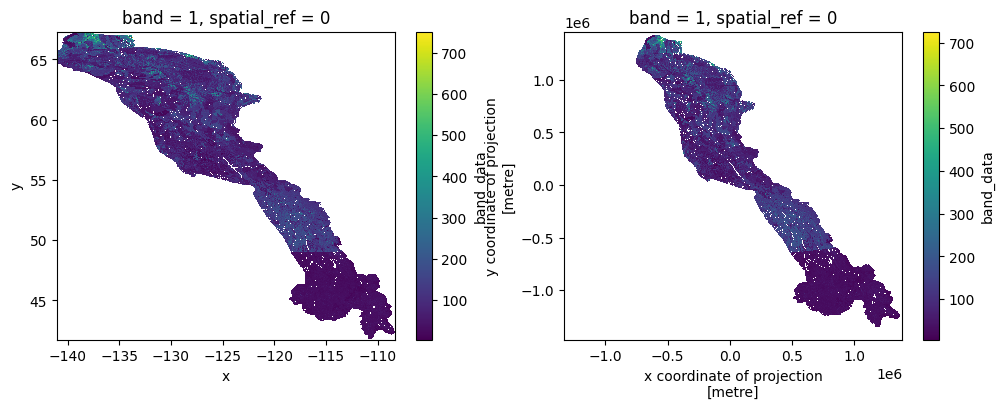

In [14]:
# plot reprojected err layer against original to check values
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
soc_err.plot(ax=axes[0])
soc_err_laea.plot(ax=axes[1])
plt.draw()

In [15]:
# reproject lc layer
# use mode resampling for landcover
lc_laea = lc.rio.reproject_match(carbon_laea, resampling = Resampling.mode, NODATA_VALUES_PCT_THRESHOLD=50)
print_raster(lc_laea)

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 133465320.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",-125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: nan
NoDataOriginalValues: 0.0



In [16]:
# use assign_cords to make sure an exact match (issue with floating precision)
carbon_err_laea = carbon_err_laea.assign_coords({
    "x": carbon_laea.x,
    "y": carbon_laea.y,
})

soc_laea = soc_laea.assign_coords({
    "x": carbon_laea.x,
    "y": carbon_laea.y,
})

soc_err_laea = soc_err_laea.assign_coords({
    "x": carbon_laea.x,
    "y": carbon_laea.y,
})

lc_laea = lc_laea.assign_coords({
    "x": carbon_laea.x,
    "y": carbon_laea.y,
})

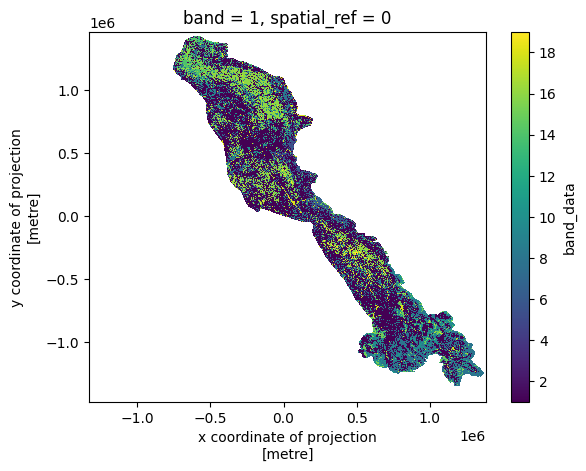

In [17]:
# plot LC layer
lc_laea.plot()

In [18]:
# mask carbon values corresponding to water and snow/ice landcover
ignore_classes = [18, 19] # 18 = water, 19 = snow/ice

# mask water and snow/ice
for val in ignore_classes:
    carbon_laea = carbon_laea.where(lc_laea!=val, other=np.nan)
    carbon_err_laea = carbon_err_laea.where(lc_laea!=val, other=np.nan)
    soc_laea = soc_laea.where(lc_laea!=val, other=np.nan)
    soc_err_laea = soc_err_laea.where(lc_laea!=val, other=np.nan)

In [ ]:
# round to one decimal
carbon_laea = carbon_laea.round(1)
carbon_err_laea = carbon_err_laea.round(1)
soc_laea = soc_laea.round(1)
soc_err_laea = soc_err_laea.round(1)

# write no data values into metadata
print_raster(carbon_laea)
carbon_laea.rio.write_nodata(-9999, encoded=True, inplace=True)
carbon_err_laea.rio.write_nodata(-9999, encoded=True, inplace=True)
soc_laea.rio.write_nodata(-9999, encoded=True, inplace=True)
soc_err_laea.rio.write_nodata(-9999, encoded=True, inplace=True)
print_raster(carbon_laea)
print_raster(carbon_err_laea)
print_raster(soc_laea)
print_raster(soc_err_laea)

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 888272128.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",-125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: None
NoDataOriginalValues: None

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 888272128.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],

In [20]:
# export rasters
carbon_laea.rio.to_raster(carbon_path.replace('.tif', '_laea.tif'))
carbon_err_laea.rio.to_raster(carbon_err_path.replace('.tif', '_laea.tif'))
soc_laea.rio.to_raster(soc_path.replace('.tif', '_laea.tif'))
soc_err_laea.rio.to_raster(soc_err_path.replace('.tif', '_laea.tif'))

In [21]:
# multiply by area to get a total t Carbon per cell
# since we are multiplying by a constant error values are also multiplied by the constant
carbon_laea_t = carbon_laea * ((250*250)/(100*100))
carbon_err_laea_t = carbon_err_laea * ((250*250)/(100*100))
soc_laea_t = soc_laea * ((250*250)/(100*100))
soc_err_laea_t = soc_err_laea * ((250*250)/(100*100))
print_raster(carbon_laea_t)

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 5551676928.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",-125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: None
NoDataOriginalValues: None



In [ ]:
# round to one decimal
carbon_laea_t = carbon_laea_t.round(1)
carbon_err_laea_t = carbon_err_laea_t.round(1)
soc_laea_t = soc_laea_t.round(1)
soc_err_laea_t = soc_err_laea_t.round(1)

# write no data values into metadata
carbon_laea_t.rio.write_nodata(-9999, encoded=True, inplace=True)
carbon_err_laea_t.rio.write_nodata(-9999, encoded=True, inplace=True)
soc_laea_t.rio.write_nodata(-9999, encoded=True, inplace=True)
soc_err_laea_t.rio.write_nodata(-9999, encoded=True, inplace=True)
print_raster(carbon_laea_t)

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 5551676928.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",-125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: nan
NoDataOriginalValues: -9999.0



In [22]:
# export rasters
carbon_laea_t.rio.to_raster(carbon_path.replace('t_ha.tif', 't_laea.tif'))
carbon_err_laea_t.rio.to_raster(carbon_err_path.replace('t_ha.tif', 't_laea.tif'))
soc_laea_t.rio.to_raster(soc_path.replace('t_ha.tif', 't_laea.tif'))
soc_err_laea_t.rio.to_raster(soc_err_path.replace('t_ha.tif', 't_laea.tif'))
lc_laea.rio.to_raster(lc_path.replace('.tif', '_laea.tif'))